In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import torch
import json
from matplotlib.colors import ListedColormap
from ops.utils import extract_color_masks,sort_and_filter_images,open_frame_firstlight,save_numpy_as_png
import re
from pathlib import Path

colors_info = {
    "green": ([40, 40, 40], [80, 255, 255]),
    "red": ([0, 70, 50], [10, 255, 255]),
    "red_high": ([170, 70, 50], [180, 255, 255]),
    "blue": ([100, 70, 50], [140, 255, 255]),
}

image_meta_data = {'height': 512, 'width': 640}
vis_dpi = 1200 
width = image_meta_data['width']
height = image_meta_data['height']
fig_width = width / vis_dpi
fig_height = height / vis_dpi

In [2]:
# Type 1 masks (The most common type, starting from scratch)
masks_directory = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240611/20240604_13_00/CREDgt_set_1/CREDgt_set_1/Masks"
raw_video_dir = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240611/20240604_13_00/20240604_13_00_11062024_135808.raw"
# Type 2 masks (Modifying SAM masks)
modefication_masks_dir = None
sam_masks_dir = modefication_masks_dir.replace("manual mask", "original") if modefication_masks_dir else None
# Type 3 masks (Only for gt1. Meltpool and flood masks)
meltpool_flood_dir_mp = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240611/20240604_13_00/labelled/Mask" # Meltpool final masks
meltpool_flood_dir_flood = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240611/20240604_13_00/20240604_13_00_v2/20240604_13_00_v2/Masks" # flood mask, union of meltpool and voids masks


# Type 1 masks (The most common type, starting from scratch)
masks_directory = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240626/20240626_03_00/CREDgt_set_2/Masks"
raw_video_dir = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240626/20240626_03_00/20240626_03_00_26062024_155807.raw"
# Type 2 masks (Modifying SAM masks)
modefication_masks_dir = None
sam_masks_dir = modefication_masks_dir.replace("manual mask", "original") if modefication_masks_dir else None
# Type 3 masks (Only for gt1. Meltpool and flood masks)
meltpool_flood_dir_mp =None# Meltpool final masks
meltpool_flood_dir_flood = None # flood mask, union of meltpool and voids masks


# Type 1 masks (The most common type, starting from scratch)
masks_directory = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240711/20240708_07_02/CREDgt_set_3_v2/Mask"
raw_video_dir = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240711/20240708_07_02/20240708_07_02_11072024_175349.raw"
# Type 2 masks (Modifying SAM masks)
modefication_masks_dir = None
sam_masks_dir = modefication_masks_dir.replace("manual mask", "original") if modefication_masks_dir else None
# Type 3 masks (Only for gt1. Meltpool and flood masks)
meltpool_flood_dir_mp =None# Meltpool final masks
meltpool_flood_dir_flood = None # flood mask, union of meltpool and voids masks


# # Type 1 masks (The most common type, starting from scratch)
# masks_directory = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240712/CRED/20240708_09_00/CREDgt_set_4_v3/CREDgt_set_4/Masks/"
# raw_video_dir = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240712/CRED/20240708_09_00/20240708_09_00_12072024_113101.raw"
# # Type 2 masks (Modifying SAM masks)
# modefication_masks_dir = "/home/mohamed/data2/projects/AM/Data/RAW/ByDay/20240712/CRED/20240708_09_00/manual modification/modification/manual mask/"
# sam_masks_dir = modefication_masks_dir.replace("manual mask", "original") if modefication_masks_dir else None
# # Type 3 masks (Only for gt1. Meltpool and flood masks)
# meltpool_flood_dir_mp = None
# meltpool_flood_dir_flood = None


# Type 1 masks (The most common type, starting from scratch)
masks_directory = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240801/20240801gt_set_5/20240801gt_set_5/Masks"
raw_video_dir = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240801/20240713_20_00_01082024_145636.raw"
# Type 2 masks (Modifying SAM masks)
modefication_masks_dir = None
sam_masks_dir = modefication_masks_dir.replace("manual mask", "original") if modefication_masks_dir else None
# Type 3 masks (Only for gt1. Meltpool and flood masks)
meltpool_flood_dir_mp =None# Meltpool final masks
meltpool_flood_dir_flood = None # flood mask, union of meltpool and voids masks


out_dir = raw_video_dir.replace("/Data/RAW/ByDay/", "/Data/Processed/Masks/").replace(".raw", "/")
os.makedirs(Path(out_dir), exist_ok=True)
os.makedirs(Path(out_dir)/'checks', exist_ok=True)


image_meta_data.update({'filename_abs': raw_video_dir})

In [3]:
out_dir

'/mnt/md126/users/mohamed/projects/AM/Data/Processed/Masks/20240801/20240713_20_00_01082024_145636/'

# Flood and Meltpool Masks

In [4]:
if meltpool_flood_dir_flood is not None:
    meltpool_flood_dir_masks = os.listdir(meltpool_flood_dir_mp) 
    total_num_masks = len(meltpool_flood_dir_masks)
else:
    total_num_masks = 0
print(f"Total number of masks: {total_num_masks}")

Total number of masks: 0


In [5]:
if total_num_masks >0:
    fig, ax = plt.subplots(total_num_masks, 2, figsize=(10, 2*total_num_masks),squeeze=False)
    for i in range(total_num_masks):
        meltpool_mask_path = meltpool_flood_dir_masks[i]
        match = re.search(r'_f_(\d+)_', meltpool_mask_path)
        if match:
            frame_number = int(match.group(1))  # Convert the found string number to an integer
            print(f"Mask: {meltpool_mask_path}, Frame number: {frame_number}")
        else: 
            raise ValueError(f"Could not find frame number in the mask name")
    
        meltpool_mask_path = os.path.join(meltpool_flood_dir_mp, meltpool_mask_path)
        meltpool = extract_color_masks(meltpool_mask_path, colors_info)["red"]
        mask_frame = open_frame_firstlight(image_meta_data, frame_number)['img']
        meltpool_mask = np.logical_and(meltpool, meltpool).astype(int)
        
        ## Export the masks
        frame_number_str = str(frame_number).zfill(15)
        mask_out_path_export = os.path.join(out_dir, f"mask_{frame_number_str}.png")
        orginal_image_export = os.path.join(out_dir, f"input_{frame_number_str}.png")
        save_numpy_as_png(meltpool_mask,mask_out_path_export,(fig_width, fig_height),vis_dpi,cmap = ListedColormap(['black', 'white']))
        save_numpy_as_png(mask_frame,orginal_image_export,(fig_width, fig_height),vis_dpi,cmap = 'gray')
        
        ax[i, 0].imshow(mask_frame, cmap='gray')
        ax[i, 0].set_title(f"Frame {frame_number}")
        ax[i, 1].imshow(meltpool_mask, cmap=ListedColormap(['black', 'white']) )
        ax[i, 1].set_title("Meltpool")
        for a in ax.flatten():
            a.axis('off')
            
    # zero pad and remove space between images
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace = 0.2)
    plt.savefig(Path(out_dir)/'checks/mask_flood.png', dpi=vis_dpi)
    plt.show()  

## All Xinyue

In [6]:
flood_masks = sort_and_filter_images(masks_directory, "_c1")   # Sort and filter the images
voids_masks = sort_and_filter_images(masks_directory, "_c2")   # Sort and filter the images
total_num_masks = len(flood_masks)
print(f"Total number of masks: {total_num_masks}")

Total number of masks: 10


Mask: 20240713_20_00_01082024_145636_f_11115_c1.jpg, Frame number: 11115
Mask: 20240713_20_00_01082024_145636_f_12829_c1.jpg, Frame number: 12829
Mask: 20240713_20_00_01082024_145636_f_19685_c1.jpg, Frame number: 19685
Mask: 20240713_20_00_01082024_145636_f_23113_c1.jpg, Frame number: 23113
Mask: 20240713_20_00_01082024_145636_f_24827_c1.jpg, Frame number: 24827
Mask: 20240713_20_00_01082024_145636_f_31683_c1.jpg, Frame number: 31683
Mask: 20240713_20_00_01082024_145636_f_53965_c1.jpg, Frame number: 53965
Mask: 20240713_20_00_01082024_145636_f_79675_c1.jpg, Frame number: 79675
Mask: 20240713_20_00_01082024_145636_f_148235_c1.jpg, Frame number: 148235
Mask: 20240713_20_00_01082024_145636_f_163661_c1.jpg, Frame number: 163661


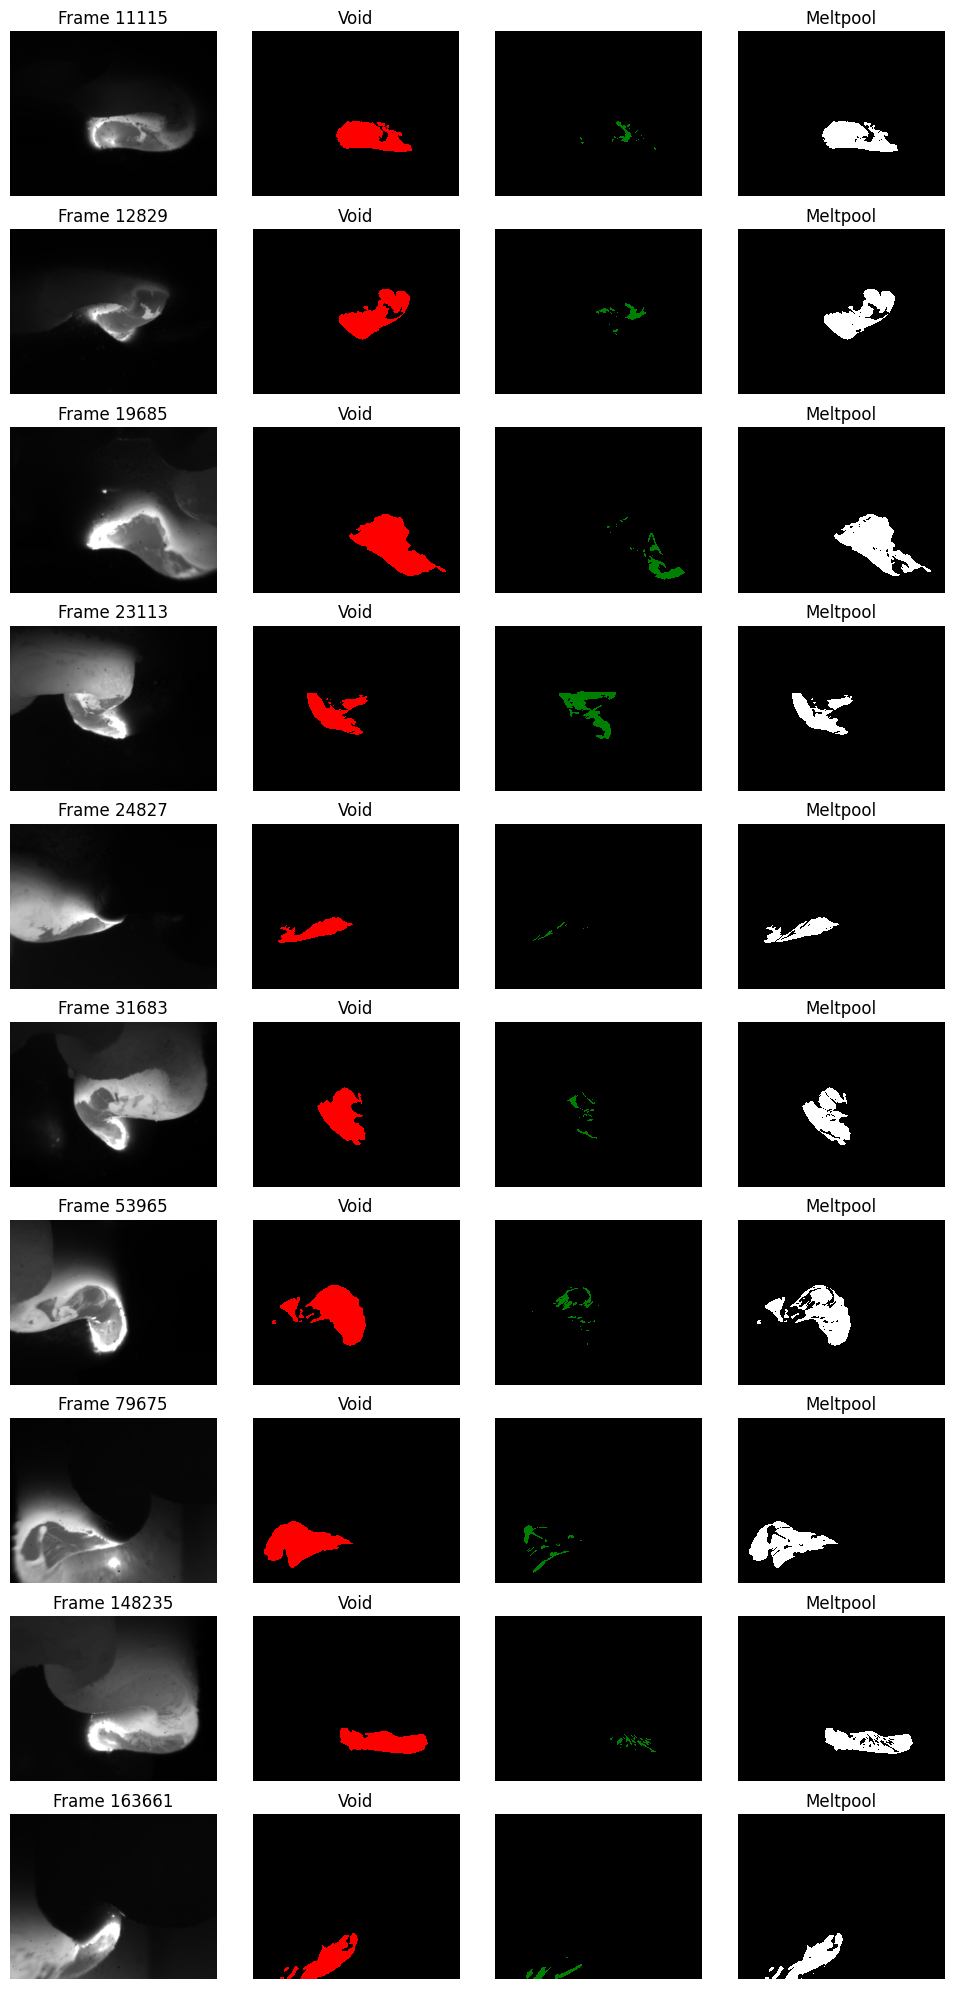

In [7]:

fig, ax = plt.subplots(total_num_masks, 4, figsize=(10, 2*total_num_masks),squeeze=False)
for i in range(len(flood_masks)):
    flood_mask_path = flood_masks[i]
    match = re.search(r'_f_(\d+)_c1', flood_mask_path)
    if match:
        frame_number = int(match.group(1))  # Convert the found string number to an integer
        print(f"Mask: {flood_mask_path}, Frame number: {frame_number}")
    else: 
        raise ValueError(f"Could not find frame number in the mask name")
    void_mask_path = [mask for mask in voids_masks if f"_f_{frame_number}_c2" in mask]
    if len(void_mask_path) == 0:
        void_mask_path = None
    elif len(void_mask_path) == 1:
        void_mask_path = void_mask_path[0]
    else:
        raise ValueError(f"Found more than one void mask for frame {frame_number}")
    
    flood_mask_path_ = os.path.join(masks_directory, flood_mask_path)
    void_mask_path_ = os.path.join(masks_directory, void_mask_path) if void_mask_path is not None else None
    flood = extract_color_masks(flood_mask_path_, colors_info)["red"]
    void = extract_color_masks(void_mask_path_, colors_info)["green"] if void_mask_path is not None else np.zeros_like(flood)
    mask_frame = open_frame_firstlight(image_meta_data, frame_number)['img']
    meltpool_mask = np.logical_and(flood, np.logical_not(void)).astype(int)
    
    ## Export the masks
    frame_number_str = str(frame_number).zfill(15)
    mask_out_path_export = os.path.join(out_dir, f"mask_{frame_number_str}.png")
    orginal_image_export = os.path.join(out_dir, f"input_{frame_number_str}.png")
    save_numpy_as_png(meltpool_mask,mask_out_path_export,(fig_width, fig_height),vis_dpi,cmap = ListedColormap(['black', 'white']))
    save_numpy_as_png(mask_frame,orginal_image_export,(fig_width, fig_height),vis_dpi,cmap = 'gray')
    
    ax[i, 0].imshow(mask_frame, cmap='gray')
    ax[i, 0].set_title(f"Frame {frame_number}")
    ax[i, 1].imshow(flood, cmap=ListedColormap(['black', 'red']) )
    ax[i, 1].set_title("Flood")
    ax[i, 2].imshow(void, cmap=ListedColormap(['black', 'green']) )
    ax[i, 1].set_title("Void")
    ax[i, 3].imshow(meltpool_mask, cmap=ListedColormap(['black', 'white']) )
    ax[i, 3].set_title("Meltpool")
    
    
    for a in ax.flatten():
        a.axis('off')
        
# zero pad and remove space between images
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace = 0.2)
plt.savefig(Path(out_dir)/'checks/void_flood.png', dpi=vis_dpi)
plt.show()  

## SAM modefied Masks

In [8]:
if modefication_masks_dir is not None:
    modefication_masks = os.listdir(modefication_masks_dir)
    sam_masks = os.listdir(sam_masks_dir)
    total_num_masks = len(modefication_masks)
else :
    total_num_masks = 0
print(f"Total number of masks: {total_num_masks}")

Total number of masks: 0


In [9]:
if total_num_masks > 0:
    fig, ax = plt.subplots(total_num_masks, 6, figsize=(15, 2*total_num_masks),squeeze=False)
    for i in range(total_num_masks):
        mask = modefication_masks[i]
        mask_path = os.path.join(modefication_masks_dir, mask)
        match = re.search(r'_(\d+)-', mask)
        if match:
            frame_number = int(match.group(1))  # Convert the found string number to an integer
            print(f"Mask: {mask}, Frame number: {frame_number}")
        else: 
            raise ValueError(f"Could not find frame number in the mask name")
        xinyue = Image.open(mask_path)
        sam_mask_path = [x for x in sam_masks if str(frame_number) in x][0]
        sam_mask_path_ = os.path.join(sam_masks_dir, sam_mask_path)
        sam_image = Image.open(sam_mask_path_)
        sam_mask =  extract_color_masks(sam_mask_path_, colors_info)["blue"]
        xinyue_masks = extract_color_masks(mask_path, colors_info)
        to_remove = xinyue_masks["green"]
        to_add = xinyue_masks["red"]
        overlayed = xinyue_masks['image']
        mask_frame = open_frame_firstlight(image_meta_data, frame_number)['img']
        single_color_cmap_red = ListedColormap(['none', 'red']) 
        single_color_cmap_green = ListedColormap(['none', 'green']) 
        meltpool_mask = np.logical_or(np.logical_and(sam_mask, np.logical_not(to_remove)), to_add).astype(int)
        
        ## Export the masks
        frame_number_str = str(frame_number).zfill(15)
        mask_out_path_export = os.path.join(out_dir, f"mask_{frame_number_str}.png")
        orginal_image_export = os.path.join(out_dir, f"input_{frame_number_str}.png")
        save_numpy_as_png(meltpool_mask,mask_out_path_export,(fig_width, fig_height),vis_dpi,cmap = ListedColormap(['black', 'white']))
        save_numpy_as_png(mask_frame,orginal_image_export,(fig_width, fig_height),vis_dpi,cmap = 'gray')
        
        ## Visualizing for checking
        ax[i, 0].imshow(overlayed)
        ax[i, 0].set_title("SAM + Xinyue")
        ax[i, 1].imshow(to_remove, cmap=ListedColormap(['black', 'green']) )
        ax[i, 1].set_title("Xinyue To remove")
        ax[i, 2].imshow(to_add, cmap=ListedColormap(['black', 'red']) )
        ax[i, 2].set_title("Xinyue To add")
        ax[i, 3].imshow(mask_frame, cmap='gray')
        ax[i, 3].set_title(f"Raw frame{frame_number}")
        IOU = np.sum(meltpool_mask * sam_mask) / np.sum(meltpool_mask + sam_mask)
        ax[i, 4].imshow(sam_mask, cmap=ListedColormap(['black', 'blue']), )
        ax[i, 4].set_title(f"SAM mask, IOU: {IOU:.2f}")
        ax[i, 5].imshow(meltpool_mask, cmap=ListedColormap(['black', 'white']) )
        ax[i, 5].set_title("Final Meltpool mask")
        
        for a in ax.flatten():
            a.axis('off')
            
    # zero pad and remove space between images
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace = 0.2)

    plt.savefig(Path(out_dir)/'checks/sam_modefied.png', dpi=vis_dpi)
    plt.show()